### Make a three-band image for Doodling
* Clip out ROI from DEM and 
* 
* Read in the DEM and normalize to 0-255
* Read in the ortho
    * Calculate panchromatic band
    * Calculate veg index band
    * Smooth and interpolate onto DEM grid
* Create 3-band image
* Export as jpg with aux.xml coordinate info

In [1]:
import os
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
import numpy as np
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Define functions for work on images

In [2]:
def normalized_uint8( a, nan_val = 0 ):
    amin = np.nanmin(a)
    amax = np.nanmax(a)
    a_shape = np.shape(a)
    ar = np.ravel(a)
    ar[np.where(np.isnan)] = nan_val
    ar = np.round(255*(ar-amin)/(amax-amin))
    return np.reshape(ar,a_shape).astype('uint8')


def GRRI_func(im):
    r, g, b = 0, 1, 2
    GRRI = im[:,:,g]/im[:,:,r]
    return GRRI


def GRVI_func(im):
    r, g, b = 0, 1, 2
    GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
    return GRVI


def Excess_funcs(im):
    '''
    Excess Red (ExR)
        Meyer, G. E., Hindman, T. W., and Laksmi, K. (1999). Machine vision
        detection parameters for plant species identification. in, eds.
        G. E. Meyer and J. A. DeShazer (Boston, MA), 327â€“335.
        doi:10.1117/12.336896.
    Excess Green (ExG)
        Woebbecke, D.M.; Meyer, G.E.; Von Bargen, K.; Mortensen, D.A.
        1995. Color Indices forWeed Identification Under Various Soil,
        Residue, and Lighting Conditions. Trans. ASAE, 38, 259-269.
    Excess Green minus R (ExGR)
        Neto, J.C. 2004. A combined statistical-soft computing approach
        for classification and mapping weed species in minimum -tillage
        systems. Ph.D. Thesis, University of Nebraska, Lincoln, Lincoln,
        NE, USA, August 2004.
        
    Thanks to Phil Wernette, USGS
    '''
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    exr = 1.4*b-g
    exg = 2*g-r-b
    exgr = exg-exr
    return exr, exg, exgr


def gray_func(im):
    r, g, b = 0, 1, 2
    gray = np.round(  0.2989 * im[:,:,r]
                    + 0.5870 * im[:,:,g]
                    + 0.1140 * im[:,:,b])
    return gray.astype('uint8')


def twod_stats(im):
    print('dtype:', im.dtype, 'shape', im.shape)
    print('Number of nans:',np.sum(np.isnan(np.ravel(im))))
    print('2.5% {}, 97.5% {}'.format(np.nanpercentile(im, 2.5), np.nanpercentile(im, 97.5)))
    print('1% {}, 99% {}'.format(np.nanpercentile(im, 1), np.nanpercentile(im, 99)))
    print('min {}, max {}'.format(np.nanmin(im), np.nanmax(im)))
    print('median {}, mean {}'.format(np.nanpercentile(im, 50), np.nanmean(im)))

In [3]:
big_ortho_dir = 'C:/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog/'
big_ortho_fname = '20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif'

big_dem_dir = 'C:/crs/proj/2021_FloSupp_Release/Clipped_Final/'
big_dem_fname = '20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif'

out_dir = 'C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/tiff_composites/'
ortho_fname = 'small_ortho.tif'
dem_fname = 'small_dem.tif'

# define a box
ulx=394500.
uly=3871680.
boxx = 250.
boxy = 200.

lrx=ulx+boxx
lry=uly-boxy

### Use gdal to convert the DEM from 1 m to 0.25 m

In [4]:
infile = big_dem_dir+big_dem_fname
outfile = out_dir+dem_fname
gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -tr 0.25 0.25 -r nearest -of GTiff -co COMPRESS=DEFLATE {} {}'.format(
    ulx, uly, lrx, lry, infile, outfile)
print(gdal_cmd)
os.system(gdal_cmd)
os.system('gdalinfo {}'.format(outfile))

gdal_translate -projwin 394500.0 3871680.0 394750.0 3871480.0 -b 1 -tr 0.25 0.25 -r nearest -of GTiff -co COMPRESS=DEFLATE C:/crs/proj/2021_FloSupp_Release/Clipped_Final/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/tiff_composites/small_dem.tif


0

### Open the DEM with xarray

In [5]:
dsx = xr.open_dataset(out_dir+dem_fname)
dsx

<xarray.Dataset>
Dimensions:      (band: 1, x: 1000, y: 800)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.945e+05 3.945e+05 ... 3.947e+05 3.947e+05
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.871e+06 3.871e+06
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [6]:
el = np.squeeze(np.array(dsx.band_data))
twod_stats(el)

eln = normalized_uint8(el, nan_val = np.nan)
twod_stats(eln)

dtype: float32 shape (800, 1000)
Number of nans: 624
2.5% 0.6018307209014893, 97.5% 3.8665943145751953
1% 0.540205180644989, 99% 4.475756645202637
min -0.011981863528490067, max 6.008672714233398
median 1.4906861782073975, mean 1.65524423122406
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 26.0, 97.5% 164.0
1% 23.0, 99% 190.0
min 0, max 255
median 64.0, mean 70.5579625


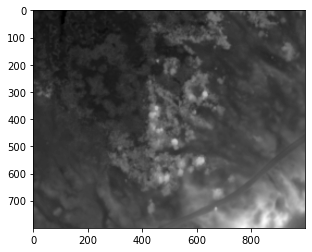

In [7]:
plt.imshow(eln, cmap='gray')

### Use Gdal to clip the same sub-region out of the big ortho

In [8]:
infile = big_ortho_dir+big_ortho_fname
outfile = out_dir+ortho_fname

gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -b 2 -b 3 -of GTiff -co COMPRESS=DEFLATE  {} {}'.format(ulx, uly, lrx, lry, infile, outfile)
print(gdal_cmd)
os.system(gdal_cmd)
os.system('gdalinfo {}'.format(outfile))

gdal_translate -projwin 394500.0 3871680.0 394750.0 3871480.0 -b 1 -b 2 -b 3 -of GTiff -co COMPRESS=DEFLATE  C:/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/tiff_composites/small_ortho.tif


0

### Read in the small ortho

In [9]:
# open the small ortho
ds = gdal.Open(out_dir+ortho_fname, gdal.GA_ReadOnly)

# Allocate an array using the first band's datatype
image_datatype = ds.GetRasterBand(1).DataType

image = np.zeros((ds.RasterYSize, ds.RasterXSize, ds.RasterCount),
                  dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# # Loop over all bands in dataset
for b in range(ds.RasterCount):
    band = ds.GetRasterBand(b + 1)   
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()

print('Band 2.5% {}, 97.5% {}'.format(np.nanpercentile(image, 2.5), np.nanpercentile(image, 97.5)))
print('Band 1% {}, 99% {}'.format(np.nanpercentile(image, 1), np.nanpercentile(image, 99)))

print('Red band mean: {r}'.format(r=image[:, :, 0].mean()))

Band 2.5% 38.0, 97.5% 187.0
Band 1% 33.0, 99% 195.0
Red band mean: 95.8808125


### Compute veg indices

In [10]:
GRRI = GRRI_func(image)
print('GRRI:')
twod_stats(GRRI)
print('\nGRRI_n')
GRRI_n = normalized_uint8( GRRI )
twod_stats(GRRI_n)

GRRI:
dtype: float64 shape (800, 1000)
Number of nans: 0
2.5% 0.95, 97.5% 1.3095238095238095
1% 0.9375, 99% 1.3636363636363635
min 0.8571428571428571, max 1.6956521739130435
median 1.0103092783505154, mean 1.0443574839278709

GRRI_n
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 28.0, 97.5% 138.0
1% 24.0, 99% 154.0
min 0, max 255
median 47.0, mean 56.87441625


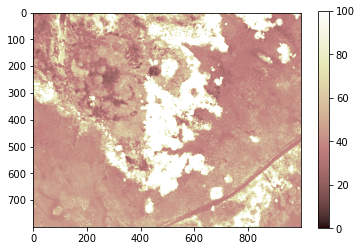

In [11]:
plt.imshow(GRRI_n, cmap = 'pink', vmin=0, vmax=100)
plt.colorbar()

In [12]:
twod_stats(image[:,:,0])
twod_stats(image[:,:,1])
twod_stats(image[:,:,2])

GRVI = GRVI_func(image)
twod_stats

dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 39.0, 97.5% 187.0
1% 34.0, 99% 195.0
min 12, max 206
median 87.0, mean 95.8808125
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 48.0, 97.5% 188.0
1% 44.0, 99% 195.0
min 18, max 208
median 88.0, mean 98.09017875
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 34.0, 97.5% 186.0
1% 30.0, 99% 194.0
min 19, max 209
median 81.0, mean 90.27314


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26084\3713389985.py:19: RuntimeWarning: divide by zero encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26084\3713389985.py:19: RuntimeWarning: invalid value encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])


<function __main__.twod_stats(im)>

C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26084\3713389985.py:19: RuntimeWarning: divide by zero encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26084\3713389985.py:19: RuntimeWarning: invalid value encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26084\3713389985.py:7: RuntimeWarning: invalid value encountered in true_divide
  ar = np.round(255*(ar-amin)/(amax-amin))


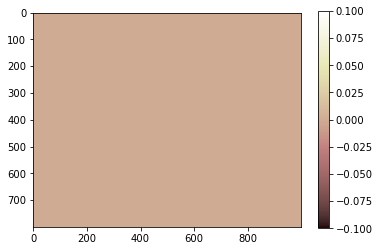

In [13]:
plt.imshow(normalized_uint8(GRVI_func(image), nan_val = np.nan), cmap = 'pink')
plt.colorbar()

### Compute grayscale image

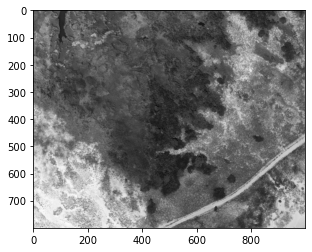

In [14]:
im_gray = gray_func(image)
plt.imshow(im_gray, cmap='gray')

### Use rasterio to read small ortho for use as a template

In [15]:
rds = rio.open_rasterio(out_dir+ortho_fname)
rds

<xarray.DataArray (band: 3, y: 800, x: 1000)>
[2400000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 3.945e+05 3.945e+05 ... 3.947e+05 3.947e+05
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.871e+06 3.871e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Build a composite image with grayscale, veg index, and elevation

In [16]:
rds[0,:,:]=im_gray
rds[1,:,:]=GRRI_n
rds[2,:,:]=eln

### Export as a .tiff file

In [17]:
composite_basename = 'composite'
rds.rio.to_raster(out_dir+composite_basename+'.tif')

### Use gdal to convert from tiff to jpeg

In [19]:
gdal_cmd = 'gdal_translate -of GTiff -co COMPRESS=DEFLATE -b 1 -b 2 -b 3 {}.tif {}.tif'.format(
    out_dir+composite_basename, out_dir+composite_basename+'_deflate')
print(gdal_cmd)
if os.system(gdal_cmd)==0:
    print('Success')
os.system('gdalinfo '+out_dir+composite_basename+'_deflate.tif')

gdal_translate -of GTiff -co COMPRESS=DEFLATE -b 1 -b 2 -b 3 C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/tiff_composites/composite.tif C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/tiff_composites/composite_deflate.tif
Success


0